In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras.optimizers import Adam
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner import RandomSearch

In [ ]:
# 구글 드라이브 불러오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/관세청/real_final_image'
file_list = os.listdir(folder_path)

In [ ]:
file_path = '/content/drive/MyDrive/관세청/updated_final_dataset.xlsx'
df = pd.read_excel(file_path)

In [ ]:
df.head()

,Name,Image URL,label
0,Elite 스트레이트 진 | 7 For All Mankind,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
1,로우라이즈 부츠컷 진 | Saint Laurent,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
2,Marlo 스트레이트 진 | Tove,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
3,Nedar 하이라이즈 스트레이트 진 | Loro Piana,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
4,스트레이트 진 | Toteme,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204


In [ ]:
df.tail()

,Name,Image URL,label
17661,NaN,NaN,6102
17662,NaN,NaN,6102
17663,NaN,NaN,6102
17664,NaN,NaN,6102
17665,NaN,NaN,6102


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17666 entries, 0 to 17665
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       11954 non-null  object
 1   Image URL  11954 non-null  object
 2   label      17666 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 414.2+ KB


In [ ]:
df

,Name,Image URL,label
0,Elite 스트레이트 진 | 7 For All Mankind,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
1,로우라이즈 부츠컷 진 | Saint Laurent,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
2,Marlo 스트레이트 진 | Tove,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
3,Nedar 하이라이즈 스트레이트 진 | Loro Piana,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
4,스트레이트 진 | Toteme,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
...,...,...,...
17661,NaN,NaN,6102
17662,NaN,NaN,6102
17663,NaN,NaN,6102
17664,NaN,NaN,6102


행이 0부터 시작하여 수집한 이미지셋과 동일한 형태로 인덱스 변경

In [ ]:
# 인덱스 변경
df.index = range(2, 17668)
df

,Name,Image URL,label
2,Elite 스트레이트 진 | 7 For All Mankind,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
3,로우라이즈 부츠컷 진 | Saint Laurent,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
4,Marlo 스트레이트 진 | Tove,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
5,Nedar 하이라이즈 스트레이트 진 | Loro Piana,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
6,스트레이트 진 | Toteme,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
...,...,...,...
17663,NaN,NaN,6102
17664,NaN,NaN,6102
17665,NaN,NaN,6102
17666,NaN,NaN,6102


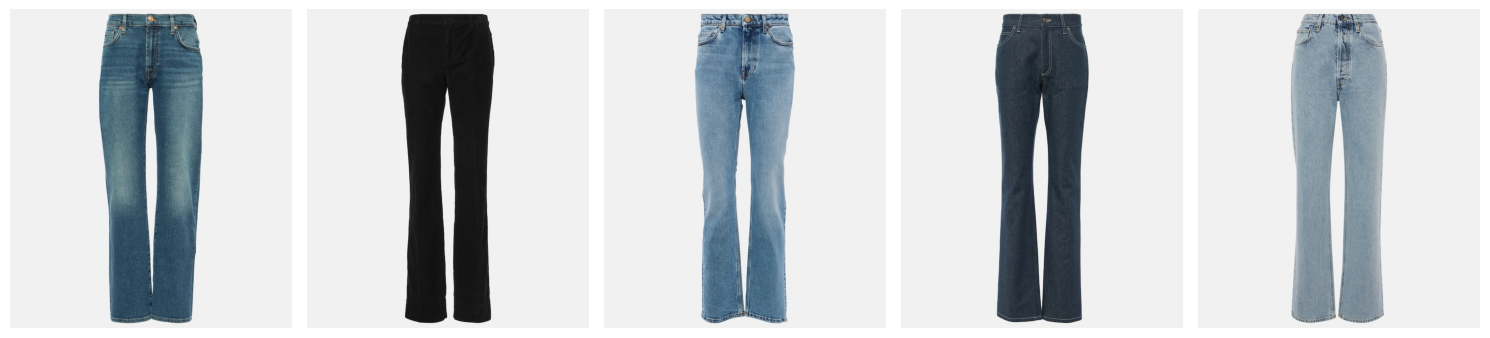

In [ ]:
import re
# 폴더 내 이미지 파일 목록 읽기 (png 형식)
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.png')]

# 파일명에서 숫자를 추출하여 정렬하기
def extract_number(filename):
    # 파일명에서 숫자 부분을 찾기 위한 정규표현식
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    else:
        return float('inf')  # 숫자가 없는 경우 무한대로 처리하여 맨 뒤로 정렬

# 파일명에서 숫자를 추출하여 정렬
image_files.sort(key=lambda f: extract_number(os.path.basename(f)))

# 상위 5개 이미지를 화면에 출력
fig = plt.figure(figsize=(15, 8))  # 큰 Figure 생성
columns = 5  # 한 줄에 출력할 이미지 수
rows = 1  # 필요한 행 수 (5개의 이미지를 5개씩 1행으로 출력)

for i, image_file in enumerate(image_files[:5]):  # 상위 5개 이미지만 반복
    # 이미지 열기
    image = Image.open(image_file)

    # Figure에 이미지 추가
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')  # 축 제거

plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
import os
import glob

def count_images_in_directory(directory, extensions=['*.jpg', '*.jpeg', '*.png','*.PNG']):
    image_files = []
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(directory, ext)))
    return len(image_files)


# 디렉토리 내의 이미지 파일 개수 출력
number_of_images = count_images_in_directory(folder_path)
print(f'Total number of images: {number_of_images}')

Total number of images: 17666


In [ ]:
import os
import cv2

image_size = (128, 128)  # 이미지 크기 조정
images = []
labels = []

# 파일 확장자 목록
extensions = ['.png', '.jpg', '.jpeg', '.PNG']

for idx in df.index:
    found = False
    for ext in extensions:
        img_path = os.path.join(folder_path, f'{idx}{ext}')
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(df.loc[idx, 'label'])  # df의 'label' 컬럼 사용
            found = True
            break  # 이미지를 찾으면 루프 종료
    if not found:
        print(f"No image found for index: {idx}")

# 이제 images와 labels 리스트가 이미지 데이터와 레이블로 채워짐


예시 인덱스 반환

In [ ]:
df[200:209]

,Name,Image URL,label
202,Le Low Baggy 로우라이즈 와이드 진 | Frame,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
203,와이드 진 | Balenciaga,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
204,하이라이즈 배럴 진 | Toteme,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
205,Izey 하이라이즈 스트레이트 진 | Ganni,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
206,하이라이즈 슬림 진 | Alaïa,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
207,레이어드 하이라이즈 와이드 진 | Y/Project,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
208,Betty 지브라 프린트 스트레이트 진 | Rotate,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
209,Dame 하이라이즈 와이드 진 | Agolde,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
210,하이라이즈 샴브레이 와이드 진 | Valentino,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204


In [ ]:
# 이미지를 numpy 배열로 변환
X = np.array(images)
y = np.array(labels)

In [ ]:
# 데이터 정규화
X = X / 255.0

In [ ]:
# 개수 맞는 지 확인
print(len(X))
print(len(y))

17666
17666


원핫 인코딩

In [ ]:
df['label'].unique()

array([6204, 6104, 6206, 6203, 6110, 6109, 6105, 6101, 6103, 6102, 6205,
       6201, 6106, 6202])

In [ ]:
# OneHotEncoder 객체 생성
ohe = OneHotEncoder(sparse=False)

# 원-핫 인코딩 적용
y = ohe.fit_transform(df[['label']])

# 인코딩된 결과 확인
y

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
# 원래의 클래스 순서 확인
original_classes = ohe.categories_[0]
print("Original classes:", original_classes)

Original classes: [6101 6102 6103 6104 6105 6106 6109 6110 6201 6202 6203 6204 6205 6206]


In [ ]:
for i, label in enumerate(original_classes):
    encoded_vector = y[df['label'] == label][0]
    print(f"Original label: {label}, Encoded vector: {encoded_vector}")

Original label: 6101, Encoded vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6102, Encoded vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6103, Encoded vector: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6104, Encoded vector: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6105, Encoded vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6106, Encoded vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6109, Encoded vector: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6110, Encoded vector: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Original label: 6201, Encoded vector: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original label: 6202, Encoded vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Original label: 6203, Encoded vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Original label: 6204, Encoded vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original label: 

In [ ]:
# train, valid, test 데이터 분리(7:2:1 비율)
from sklearn.model_selection import train_test_split

# 전체 데이터 중 70%를 train, 나머지 30%를 temp로 나눔
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# temp 데이터 중 2/3는 validation, 1/3는 test로 나눔
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# 데이터 비율 확인
print(f'Train data: {len(X_train)}')
print(f'Validation data: {len(X_valid)}')
print(f'Test data: {len(X_test)}')


Train data: 12366
Validation data: 3551
Test data: 1749


이미지 전처리

In [ ]:
# 데이터프레임에 이미지 파일 이름 컬럼 추가
df['filename'] = df.index.astype(str) + '.png'

In [ ]:
df.head()

,Name,Image URL,label,filename
2,Elite 스트레이트 진 | 7 For All Mankind,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204,2.png
3,로우라이즈 부츠컷 진 | Saint Laurent,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204,3.png
4,Marlo 스트레이트 진 | Tove,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204,4.png
5,Nedar 하이라이즈 스트레이트 진 | Loro Piana,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204,5.png
6,스트레이트 진 | Toteme,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204,6.png


In [ ]:
df.tail()

,Name,Image URL,label,filename
17663,NaN,NaN,6102,17663.png
17664,NaN,NaN,6102,17664.png
17665,NaN,NaN,6102,17665.png
17666,NaN,NaN,6102,17666.png
17667,NaN,NaN,6102,17667.png


In [ ]:
# 'label' 컬럼 값을 문자열로 변환
df['label'] = df['label'].astype(str)

In [ ]:
# 학습 및 임시 데이터 분할 (7:3)
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# 검증 및 테스트 데이터 분할 (2:1 비율)
df_valid, df_test = train_test_split(df_temp, test_size=0.33, stratify=df_temp['label'], random_state=42)

# 분할된 데이터 확인
print(f'Train data: {len(df_train)}')
print(f'Validation data: {len(df_valid)}')
print(f'Test data: {len(df_test)}')

Train data: 12366
Validation data: 3551
Test data: 1749


In [ ]:
# ImageDataGenerator 설정
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# 학습 데이터 제너레이터
train_generator = datagen.flow_from_dataframe(
    df_train,
    directory='/content/drive/MyDrive/관세청/real_final_image',
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 11939 validated image filenames belonging to 14 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 427 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# 검증 데이터 제너레이터
validation_generator = datagen.flow_from_dataframe(
    df_valid,
    directory='/content/drive/MyDrive/관세청/real_final_image',
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3403 validated image filenames belonging to 14 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 148 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# 테스트 데이터 제너레이터
test_generator = datagen.flow_from_dataframe(
    df_test,
    directory='/content/drive/MyDrive/관세청/real_final_image',
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1671 validated image filenames belonging to 14 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 78 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# 클래스 수 계산
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 14


vgg16 모델 - 16개 층으로 이미지 학습

모델링

In [ ]:
# VGG16 모델 불러오기 (사전 훈련된 가중치 사용)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


하이퍼파라미터 튜닝

In [ ]:
def model_builder(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(hp.Int('units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(len(train_generator.class_indices), activation='softmax'))

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,  # 시도 횟수
    executions_per_trial=1,
    directory='vgg16_tuning',
    project_name='vgg16_tuning_project'
)

In [ ]:
# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 튜너 검색 수행
tuner.search(train_generator, validation_data=validation_generator, epochs=10, callbacks=[early_stopping])

# 최적의 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
최적의 하이퍼파라미터:
- Dense 레이어 유닛 수: {best_hps.get('units')}
- Dropout 비율: {best_hps.get('dropout')}
- 학습률: {best_hps.get('learning_rate')}
""")

Trial 10 Complete [00h 38m 38s]
val_accuracy: 0.7857772707939148

Best val_accuracy So Far: 0.7934175729751587
Total elapsed time: 06h 21m 44s

최적의 하이퍼파라미터:
- Dense 레이어 유닛 수: 384
- Dropout 비율: 0.30000000000000004
- 학습률: 0.0004081267136080148



하이퍼 파라미터 튜닝 후 최적의 파라미터 결과로 다시 모델 학습

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 최적의 하이퍼파라미터
optimal_units = 384
optimal_dropout = 0.3
optimal_learning_rate = 0.0004081267136080148

# VGG16 모델 불러오기 (사전 훈련된 가중치 사용)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모델 구조 정의
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(optimal_units, activation='relu'),
    Dropout(optimal_dropout),
    Dense(num_classes, activation='softmax')
])

# 기존 층을 학습되지 않도록 고정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=optimal_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # 더 많은 에포크 수 설정 가능
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


373/373 ━━━━━━━━━━━━━━━━━━━━ 224s 553ms/step - accuracy: 0.3977 - loss: 2.8874 - val_accuracy: 0.6843 - val_loss: 0.9904
Epoch 2/20
  1/373 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.6250 - loss: 1.0098

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6250 - loss: 1.0098 - val_accuracy: 0.5455 - val_loss: 1.4063
Epoch 3/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 208s 549ms/step - accuracy: 0.6756 - loss: 0.9943 - val_accuracy: 0.7353 - val_loss: 0.8339
Epoch 4/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - accuracy: 0.8125 - loss: 0.7745 - val_accuracy: 0.9091 - val_loss: 0.4219
Epoch 5/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 208s 548ms/step - accuracy: 0.7363 - loss: 0.7865 - val_accuracy: 0.7497 - val_loss: 0.7758
Epoch 6/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step - accuracy: 0.6562 - loss: 0.8576 - val_accuracy: 0.6364 - val_loss: 0.7307
Epoch 7/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 207s 546ms/step - accuracy: 0.7794 - loss: 0.6585 - val_accuracy: 0.7671 - val_loss: 0.7167
Epoch 8/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step - accuracy: 0.8125 - loss: 0.5156 - val_accuracy: 0.8182 - val_loss: 0.6354
Epoch 9/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 207s 546ms/step - accuracy: 0.8207 - loss: 0.5492 - val_

< vgg16 모델 최종 평가 >
- Precision : 0.7301
- Recall : 0.7301
- F1-Score : 0.7280
